# UKB obtain drug formulation and DrugxFormulation Heatmap

In [1]:
! pip install openpyxl
! hadoop fs -mkdir /resources
! wget  -nd  biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept.tsv  && hadoop fs -put omop_concept.tsv /resources/
! wget  -nd  biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_drug_strength.tsv && hadoop fs -put omop_drug_strength.tsv /resources/
! wget  -nd  biobank.ndph.ox.ac.uk/ukb/ukb/auxdata/omop_concept_relationship.tsv  && hadoop fs -put omop_concept_relationship.tsv /resources/


2025-03-18 12:41:09,333 WARN metrics.MetricsReporter: Unable to initialize metrics scraping configurations from hive-site.xml. Message:InputStream cannot be null
2025-03-18 12:41:09,447 WARN service.DNAxApiSvc: Using default configurations. Unable to find dnanexus.conf.location=null
2025-03-18 12:41:09,447 INFO service.DNAxApiSvc: apiserver connection-pool config. MaxPoolSize=10, MaxPoolPerRoute=10,MaxWaitTimeout=60000
2025-03-18 12:41:09,447 INFO service.DNAxApiSvc: initializing http connection manager pools
2025-03-18 12:41:10,992 INFO service.DNAxApiSvc: Worker process - IdleConnectionMonitorThread disabled
2025-03-18 12:41:10,992 INFO service.DNAxApiSvc: Worker process - IdleConnectionMonitorThread disabled
2025-03-18 12:41:10,992 INFO service.DNAxApiSvc: initializing DNAxApiSvc
2025-03-18 12:41:11,617 WARN service.DNAxApiSvc: Shutting down Runtime service for Connection Pools
2025-03-18 12:41:11,617 INFO service.DNAxApiSvc: shutting down httpClientConnManager
2025-03-18 12:41:11,6

In [ ]:
import pyspark
import dxpy
import dxdata
from pyspark.sql.functions import (
    col,
    to_date,
    udf,
    collect_list,
    size,
    count,
    collect_set,
)
from pyspark.sql.types import StringType

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Obtain the omop data bases from UK Biobank

In [3]:
sc = pyspark.SparkContext()
spark = pyspark.sql.SparkSession(sc)

dispensed_database_name = dxpy.find_one_data_object(
    classname="database", name="app*", folder="/", name_mode="glob", describe=True
)["describe"]["name"]
dispensed_dataset_id = dxpy.find_one_data_object(
    typename="Dataset", name="app*.dataset", folder="/", name_mode="glob"
)["id"]

spark.sql("USE " + dispensed_database_name)

dataset = dxdata.load_dataset(id=dispensed_dataset_id)

In [51]:
# Init pyspark and load dataframe
# Load the 'omop_drug_era' 'omop_drug_exposure' tables
omop_drug_era = "omop_drug_era"
omop_drug_exposure = "omop_drug_exposure"

# Load tables
drug_era = dataset[omop_drug_era]
drug_exposure = dataset[omop_drug_exposure]

# Extract all field names from the tables
field_names_era = [f.name for f in drug_era.fields]
field_names_exposure = [f.name for f in drug_exposure.fields]

# Retrieve the fields
df_era = drug_era.retrieve_fields(names=field_names_era, engine=dxdata.connect())
df_exposure = drug_exposure.retrieve_fields(
    names=field_names_exposure, engine=dxdata.connect()
)

# Read the TSV file with the specified data types
df_concept = spark.read.csv(
    "/resources/omop_concept.tsv", sep="\t", header=True, inferSchema=True
)
df_drug_strength = spark.read.csv(
    "/resources/omop_drug_strength.tsv", sep="\t", header=True, inferSchema=True
)

# Display first few rows of each DataFrame
print(df_concept.columns)
print(df_drug_strength.columns)
print(df_era.columns)
print(df_exposure.columns)

/opt/conda/lib/python3.11/site-packages/thrift/transport/TSSLSocket.py:53: DeprecationWarning: ssl.PROTOCOL_TLS is deprecated
  self._context = ssl.SSLContext(ssl_version)


['concept_id', 'concept_name', 'domain_id', 'vocabulary_id', 'concept_class_id', 'standard_concept', 'concept_code', 'valid_start_date', 'valid_end_date', 'invalid_reason']
['drug_concept_id', 'ingredient_concept_id', 'amount_value', 'amount_unit_concept_id', 'numerator_value', 'numerator_unit_concept_id', 'denominator_value', 'denominator_unit_concept_id', 'box_size', 'valid_start_date', 'valid_end_date', 'invalid_reason']
['eid', 'drug_era_id', 'drug_concept_id', 'drug_era_start_date', 'drug_era_end_date', 'drug_exposure_count', 'gap_days']
['eid', 'drug_exposure_id', 'drug_concept_id', 'drug_exposure_start_date', 'drug_exposure_start_datetime', 'drug_exposure_end_date', 'drug_exposure_end_datetime', 'verbatim_end_date', 'drug_type_concept_id', 'stop_reason', 'refills', 'quantity', 'days_supply', 'sig', 'route_concept_id', 'lot_number', 'provider_id', 'visit_occurrence_id', 'visit_detail_id', 'drug_source_value', 'drug_source_concept_id', 'route_source_value', 'dose_unit_source_value

Obtain the "ingredient_concept_id" for each prescription in the drug exposure dataset using the drug_strength table

In [52]:
# Define the relevant columns
relevant_columns_drug_exposure = [
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "drug_source_value",
]

# Filter out the columns that are relevant for the EDA
df_exposure = df_exposure.select(relevant_columns_drug_exposure)

# Ensure 'drug_concept_id' in drug_exposure_df is an integer
df_exposure = df_exposure.withColumn(
    "drug_concept_id", col("drug_concept_id").cast("int")
)

relevant_columns_drug_strength = ["drug_concept_id", "ingredient_concept_id"]

# Filter out the columns that are relevant
df_drug_strength = df_drug_strength.select(relevant_columns_drug_strength)

# Ensure 'drug_concept_id in df_concept is an integer
df_drug_strength = df_drug_strength.withColumn(
    "drug_concept_id", col("drug_concept_id").cast("int")
)

drug_exposure_df_ingredient_id = df_exposure.join(
    df_drug_strength,
    "drug_concept_id",  # This ensures 'drug_concept_id' is only included once
    how="left",
)

print(drug_exposure_df_ingredient_id.columns)

['drug_concept_id', 'eid', 'drug_exposure_start_date', 'drug_exposure_end_date', 'drug_source_value', 'ingredient_concept_id']


Now we want to filter the drugs on interest from drug_exposure using the "ingredient_concept_id"

First obtain the drug id with drug_era_atc.tsv table and the atc_dict.py to obtain the ATC of each drug.

In [ ]:
# Load the table
df_ATC = pd.read_csv("mappings/drug_era/drug_era_atc.tsv", sep="\t")

# Convert concept_name and drugs_to_filter to lowercase for case-insensitive filtering
df_ATC["concept_name_lower"] = df_ATC["concept_name"].str.lower()

# List of drugs to filter (we are focusing here on drugs targeting OPRM1)
drugs_to_filter = [
    "Loperamide",
    "Morphine",
    "Methadone",
    "Fentanyl",
    "Sufentanil",
    "3-Methylfentanyl",
    "3-Methylthiofentanyl",
    "Alfentanil",
    "Alvimopan",
    "Amisulpride",
    "Amitriptyline",
    "Anileridine",
    "Aripiprazole",
    "Buprenorphine",
    "Butorphanol",
    "Butyrfentanyl",
    "Cannabidiol",
    "Carfentanil",
    "Codeine",
    "Dextromethorphan",
    "Dextropropoxyphene",
    "Dezocine",
    "Diamorphine",
    "Dihydromorphine",
    "Dimethylthiambutene",
    "Diphenoxylate",
    "Diprenorphine",
    "Eluxadoline",
    "Epicept Np-1",
    "Ethylmorphine",
    "Etorphine",
    "Hydrocodone",
    "Hydromorphone",
    "Ketamine",
    "Ketobemidone",
    "Li-301",
    "Levacetylmethadol",
    "Levallorphan",
    "Levorphanol",
    "Loxicodegol",
    "Cannabis",
    "Meperidine",
    "Metenkefalin",
    "Methadyl Acetate",
    "Methylnaltrexone",
    "Morphine Glucuronide",
    "Nabiximols",
    "Nalbuphine",
    "Naldemedine",
    "Nalmefene",
    "Naloxegol",
    "Naloxone",
    "Naltrexone",
    "Oliceridine",
    "Ondansetron",
    "Opium",
    "Oxycodone",
    "Oxymorphone",
    "Pentazocine",
    "Pentoxyverine",
    "Pholcodine",
    "Remifentanil",
    "Samidorphan",
    "Tapentadol",
    "Tianeptine",
    "Tramadol",
    "Trimebutine",
    "V1003",
]
drugs_to_filter_lower = {drug.lower() for drug in drugs_to_filter}

# Filter rows where the lowercase drug name is in the lowercase list of drugs to filter
filtered_df_atc = df_ATC[df_ATC["concept_name"].isin(drugs_to_filter_lower)]

# Identify drugs that do not appear in the dataframe
missing_drugs = drugs_to_filter_lower - set(df_ATC["concept_name_lower"])

# Print a message if there are missing drugs
if missing_drugs:
    print(
        f"The following drugs were not found in the dataset: {', '.join(missing_drugs)}"
    )

# Drop the temporary lowercase column to keep the original dataframe clean
df_ATC.drop(columns=["concept_name_lower"], inplace=True)

# Select the required columns and rename _c13 to ATC
filtered_df_atc = filtered_df_atc[
    [
        "drug_concept_id",
        "concept_name",
        "domain_id",
        "concept_class_id",
        "concept_code",
        "valid_start_date",
        "valid_end_date",
        "invalid_reason",
        "_c13",
    ]
]

# Rename the _c13 column to ATC
filtered_df_atc.rename(columns={"_c13": "ATC"}, inplace=True)

filtered_df_atc

The following drugs were not found in the dataset: butorphanol, oxymorphone, levacetylmethadol, ethylmorphine, opium, dextropropoxyphene, carfentanil, eluxadoline, diprenorphine, hydrocodone, v1003, levorphanol, samidorphan, 3-methylthiofentanyl, cannabis, methadyl acetate, diamorphine, levallorphan, dezocine, loxicodegol, sufentanil, naldemedine, pentoxyverine, dihydromorphine, li-301, etorphine, butyrfentanyl, 3-methylfentanyl, epicept np-1, metenkefalin, methylnaltrexone, nabiximols, nalbuphine, trimebutine, dimethylthiambutene, oliceridine, anileridine, morphine glucuronide, remifentanil, alvimopan, tianeptine, ketobemidone


,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03


In [ ]:
# Import the ATC dictionaries from atc_dict.py (look in which directory it is located)
from src.project_permed.atc_dict import atc_1st_level, atc_2nd_level

# Map first level ATC codes
filtered_df_atc["ATC_First_Level"] = filtered_df_atc["ATC"].apply(
    lambda x: x[0] if isinstance(x, str) else None
)
filtered_df_atc["ATC_Second_Level"] = filtered_df_atc["ATC"].apply(
    lambda x: x[:3] if isinstance(x, str) else None
)

# Map the names of the first and second level ATC categories using the imported dictionaries
filtered_df_atc["First_Level_Name"] = filtered_df_atc["ATC_First_Level"].map(
    atc_1st_level
)
filtered_df_atc["Second_Level_Name"] = filtered_df_atc["ATC_Second_Level"].map(
    lambda x: atc_2nd_level.get(x[0], {}).get(x, "Unknown")
)

filtered_df_atc

,drug_concept_id,concept_name,domain_id,concept_class_id,concept_code,valid_start_date,valid_end_date,invalid_reason,ATC,ATC_First_Level,ATC_Second_Level,First_Level_Name,Second_Level_Name
52,930916,diphenoxylate,Drug,Ingredient,3500,1970-01-01,2099-12-31,NaN,A07DA01,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."
64,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N01AH01,N,N01,Nervous System,Anesthetics
65,1154029,fentanyl,Drug,Ingredient,4337,1970-01-01,2099-12-31,NaN,N02AB03,N,N02,Nervous System,Analgesics
99,1102527,meperidine,Drug,Ingredient,6754,1970-01-01,2099-12-31,NaN,N02AB02,N,N02,Nervous System,Analgesics
101,1103640,methadone,Drug,Ingredient,6813,1970-01-01,2099-12-31,NaN,N07BC02,N,N07,Nervous System,Other Nervous System Drugs
271,757688,aripiprazole,Drug,Ingredient,89013,1970-01-01,2099-12-31,NaN,N05AX12,N,N05,Nervous System,Psycholeptics
322,45774613,naloxegol,Drug,Ingredient,1551777,2014-12-01,2099-12-31,NaN,A06AH03,A,A06,Alimentary Tract and Metabolism,Drugs for Constipation
334,710062,amitriptyline,Drug,Ingredient,704,1970-01-01,2099-12-31,NaN,N06AA09,N,N06,Nervous System,Psychoanaleptics
418,785649,ketamine,Drug,Ingredient,6130,1970-01-01,2099-12-31,NaN,N01AX03,N,N01,Nervous System,Anesthetics
421,991876,loperamide,Drug,Ingredient,6468,1970-01-01,2099-12-31,NaN,A07DA03,A,A07,Alimentary Tract and Metabolism,"Antidiarrheals, Intestinal Anti-inflammatory/A..."


In [55]:
# Save the filtered table to a new file
filtered_df_atc.to_csv("filtered_drug_atc.tsv", sep="\t", index=False)

In [56]:
# Load the `filtered_drug_atc.tsv` file as a Pandas DataFrame
drug_mapping_df = pd.read_csv("filtered_drug_atc.tsv", sep="\t")
# Extract `drug_concept_id` values as a list
drug_concept_ids = drug_mapping_df["drug_concept_id"].dropna().unique().tolist()
drug_concept_ids

[930916,
 1154029,
 1102527,
 1103640,
 757688,
 45774613,
 710062,
 785649,
 991876,
 1714319,
 1000560,
 19014158,
 19024213,
 19026459,
 1133201,
 1103314,
 19057607,
 19059528,
 1114220,
 1130585,
 1510417,
 1201620,
 1119510,
 1126658,
 1110410,
 1124957]

In [57]:
# Filter the OMOP dataset for relevant drug_concept_id
drug_exposure_df_ingredient_id_filtered = drug_exposure_df_ingredient_id.filter(
    col("ingredient_concept_id").isin(drug_concept_ids)
)
# Format date columns
drug_exposure_df_ingredient_id_filtered = (
    drug_exposure_df_ingredient_id_filtered.withColumn(
        "drug_exposure_start_date",
        to_date(col("drug_exposure_start_date"), "dd/MM/yyyy"),
    ).withColumn(
        "drug_exposure_end_date", to_date(col("drug_exposure_end_date"), "dd/MM/yyyy")
    )
)

# Show the result of the filter
drug_exposure_df_ingredient_id_filtered.drop("eid").show(truncate=False)
drug_exposure_df_ingredient_id_filtered.count()

+---------------+------------------------+----------------------+---------------------------------------------------+---------------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|drug_source_value                                  |ingredient_concept_id|
+---------------+------------------------+----------------------+---------------------------------------------------+---------------------+
|792581         |2011-08-05              |2011-09-03            |Tradorec XL 300mg tablets (Paladin Labs Europe Ltd)|1103314              |
|792581         |2007-01-22              |2007-02-20            |Tradorec XL 300mg tablets (Paladin Labs Europe Ltd)|1103314              |
|792581         |2011-08-11              |2011-09-09            |Tradorec XL 300mg tablets (Paladin Labs Europe Ltd)|1103314              |
|792581         |2011-08-19              |2011-09-17            |Tradorec XL 300mg tablets (Paladin Labs Europe Ltd)|1103314              |
|792581         |201

2558242

In [ ]:
# Delete duplicates
drug_exposure_df_ingredient_id_filtered = (
    drug_exposure_df_ingredient_id_filtered.dropDuplicates(
        ["eid", "drug_concept_id", "drug_exposure_start_date", "drug_exposure_end_date"]
    )
)
drug_exposure_df_ingredient_id_filtered.count()

2554090

Obtain the drug name from the ingredient_concept_id and the prescription name from the drug_concept_id

In [59]:
# Define the relevant columns for EDA
relevant_columns_concept = [
    "concept_id",
    "concept_name",
    "vocabulary_id",
    "concept_code",
    "concept_class_id",
]

# Filter out the columns that are relevant
df_concept = df_concept.select(relevant_columns_concept)
# Ensure 'concept_id' in df_concept is an integer
df_concept = df_concept.withColumn("concept_id", col("concept_id").cast("int"))

# Firs we want to add the drug name base on the ingredient
# Perform a left join between the two DataFrames using 'ingredient_concept_id'
drug_exposure_df_ingredient_id_filtered = drug_exposure_df_ingredient_id_filtered.join(
    df_concept,
    drug_exposure_df_ingredient_id_filtered["ingredient_concept_id"]
    == df_concept["concept_id"],
    how="left",
)

# Rename 'concept_name' to 'drug_name'
drug_exposure_df_ingredient_id_filtered = (
    drug_exposure_df_ingredient_id_filtered.withColumnRenamed(
        "concept_name", "drug_name"
    )
)

# Select relevant columns
drug_exposure_df_ingredient_id_filtered = (
    drug_exposure_df_ingredient_id_filtered.select(
        "eid",
        "drug_concept_id",
        "drug_exposure_start_date",
        "drug_exposure_end_date",
        "drug_source_value",
        "ingredient_concept_id",
        "drug_name",  # Newly added column
    )
)

# Now we can focus on the drug_concept_id to obtain concept information
# Permform a left join between the two Spark DataFrames on 'drug_concept_id' and 'concept_id'
drug_exposure_df_merged_concept = drug_exposure_df_ingredient_id_filtered.join(
    df_concept,
    drug_exposure_df_ingredient_id_filtered["drug_concept_id"]
    == df_concept["concept_id"],
    how="left",
)

# Rename 'concept_name' to 'prescription_name'
drug_exposure_df_merged_concept = drug_exposure_df_merged_concept.withColumnRenamed(
    "concept_name", "prescription_name"
)


# Show the result with the relevant columns
drug_exposure_df_merged_concept = drug_exposure_df_merged_concept.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "drug_source_value",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "vocabulary_id",
    "concept_code",
    "concept_class_id",
)

# Show the result of the filter
drug_exposure_df_merged_concept.drop("eid").show(truncate=False)
drug_exposure_df_merged_concept.count()

+---------------+------------------------+----------------------+---------------------------------------+---------------------+-------------+----------------------------------------------------------+-------------+------------+----------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|drug_source_value                      |ingredient_concept_id|drug_name    |prescription_name                                         |vocabulary_id|concept_code|concept_class_id|
+---------------+------------------------+----------------------+---------------------------------------+---------------------+-------------+----------------------------------------------------------+-------------+------------+----------------+
|40221929       |2008-06-03              |2008-07-02            |diaU.                                  |1201620              |codeine      |acetaminophen 500 MG / codeine phosphate 15 MG Oral Tablet|RxNorm       |994043      |Clinical Drug   |
|40221929       |200

2554090

In [60]:
# Group by 'vocabulary_id' and count the occurrences of each value
vocabulary_summary = drug_exposure_df_merged_concept.groupBy("vocabulary_id").count()

# Show the result
vocabulary_summary.show(truncate=False)

+----------------+-------+
|vocabulary_id   |count  |
+----------------+-------+
|RxNorm Extension|204056 |
|RxNorm          |2350034|
+----------------+-------+



In [61]:
# Group by 'concept_class_id ' and count the occurrences of each value
concept_class_id_summary = drug_exposure_df_merged_concept.groupBy(
    "concept_class_id"
).count()

# Show the result
concept_class_id_summary.show(truncate=False)

+-------------------+-------+
|concept_class_id   |count  |
+-------------------+-------+
|Branded Drug Comp  |3757   |
|Clinical Drug      |2388284|
|Ingredient         |13355  |
|Marketed Product   |29188  |
|Clinical Drug Form |4296   |
|Branded Drug       |87826  |
|Clinical Drug Comp |111    |
|Branded Drug Form  |15335  |
|Quant Clinical Drug|11777  |
|Quant Branded Drug |161    |
+-------------------+-------+



Now we can do the mapping using the concept_relationship table to pass to obtain the the drug form id and name

In [62]:
# Read the TSV file with the specified data types
df_concept_relationship = spark.read.csv(
    "/resources/omop_concept_relationship.tsv", sep="\t", header=True, inferSchema=True
)

# Show the result of the filter
df_concept_relationship.show(truncate=False)


+------------+------------+-------------------+----------------+--------------+--------------+
|concept_id_1|concept_id_2|relationship_id    |valid_start_date|valid_end_date|invalid_reason|
+------------+------------+-------------------+----------------+--------------+--------------+
|5           |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|6           |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|9           |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|11          |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|14          |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|18          |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|20          |58          |Concept replaced by|2015-10-16      |2099-12-31    |NULL          |
|22          |58          |Concept replaced by|201

We want to focus on "RxNorm has dose form" relationship_id to obtain concept_id_2 and then using again the concept table obtain the concept_name and code_concept

Documentation:
https://github.com/OHDSI/Vocabulary-v5.0/wiki/Vocab.-RxNorm
https://github.com/OHDSI/Vocabulary-v5.0/wiki/Vocab.-RxNorm_Extension

In [63]:
# Ensure 'drug_concept_id' and 'concept_id_1' are integers
relationship_filtered = df_concept_relationship.filter(
    col("relationship_id") == "RxNorm has dose form"
).select(col("concept_id_1").cast("int"), col("concept_id_2").cast("int"))

# Perform a left join on 'drug_concept_id' = 'concept_id_1'
df_with_dose_form = drug_exposure_df_merged_concept.join(
    relationship_filtered,
    drug_exposure_df_merged_concept["drug_concept_id"]
    == relationship_filtered["concept_id_1"],
    how="left",
)

# Rename 'concept_id_2' to 'drug_form_id'
df_with_dose_form = df_with_dose_form.withColumnRenamed("concept_id_2", "drug_form_id")

# Select columns
df_with_dose_form = df_with_dose_form.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "concept_class_id",
    "drug_form_id",  # Newly added column
)

# Now we want to add the name of the drug form using concept table

# Define the relevant columns for EDA
relevant_columns_concept_2 = ["concept_id", "concept_name"]

# Filter out the columns that are relevant
df_concept_2 = df_concept.select(relevant_columns_concept_2)

# Permform a left join between the two Spark DataFrames on 'drug_concept_id' and 'concept_id'
df_with_dose_form = df_with_dose_form.join(
    df_concept_2,
    df_with_dose_form["drug_form_id"] == df_concept_2["concept_id"],
    how="left",
)

# Rename 'concept_name' to 'drug_form_name'
df_with_dose_form = df_with_dose_form.withColumnRenamed(
    "concept_name", "drug_form_name"
)

# Select final columns
df_with_dose_form = df_with_dose_form.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "concept_class_id",
    "drug_form_id",
    "drug_form_name",  # Newly added column
)

# Show the final DataFrame
df_with_dose_form.drop("eid").show(truncate=False)
df_with_dose_form.count()

+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name                                                               |concept_class_id|drug_form_id|drug_form_name              |
+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+
|1154280        |2011-10-21              |2011-11-19            |1154029              |fentanyl |fentanyl 0.4 MG Buccal Tablet                                                   |Clinical Drug   |40175589    |Buccal Tablet               |
|1154280        |2012-02-20              |2012-0

2554090

In [64]:
# Group by 'drug_form_name' and count the occurrences of each value
drug_form_name_summary = df_with_dose_form.groupBy("drug_form_name").count()

# Show the result
drug_form_name_summary.show(truncate=False)

+-----------------------------+-------+
|drug_form_name               |count  |
+-----------------------------+-------+
|Delayed Release Oral Tablet  |1679   |
|Extended Release Oral Capsule|73948  |
|Nasal Solution               |1      |
|Oral Lozenge                 |525    |
|Prefilled Syringe            |1      |
|Chewable Tablet              |27     |
|Injectable Suspension        |28     |
|Sublingual Tablet            |8452   |
|Nasal Spray                  |121    |
|Oral Granules                |354    |
|Oral Powder                  |240    |
|Extended Release Oral Tablet |116775 |
|Oral Suspension              |681    |
|Topical Solution             |1718   |
|Rectal Suppository           |149    |
|Disintegrating Oral Tablet   |63514  |
|Injection                    |408    |
|NULL                         |17223  |
|Oral Capsule                 |539387 |
|Oral Tablet                  |1561985|
+-----------------------------+-------+
only showing top 20 rows



In [65]:
# Filter rows where 'drug_form_name' is NULL
null_drug_form_rows = df_with_dose_form.filter(col("drug_form_name").isNull())

# Show the result
null_drug_form_rows.drop("eid").show(truncate=False)

+---------------+------------------------+----------------------+---------------------+---------+-----------------+----------------+------------+--------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name|concept_class_id|drug_form_id|drug_form_name|
+---------------+------------------------+----------------------+---------------------+---------+-----------------+----------------+------------+--------------+
|1103314        |2014-04-17              |2014-05-16            |1103314              |tramadol |tramadol         |Ingredient      |NULL        |NULL          |
|1103314        |2015-10-26              |2015-11-24            |1103314              |tramadol |tramadol         |Ingredient      |NULL        |NULL          |
|1103314        |2014-10-24              |2014-11-22            |1103314              |tramadol |tramadol         |Ingredient      |NULL        |NULL          |
|1103314        |2016-03-17       

In [66]:
# Filter for specific concept_class_id values
filtered_df_with_dose_form = df_with_dose_form.filter(
    col("concept_class_id").isin(
        ["Brand Name", "Branded Drug Comp", "Clinical Drug Comp"]
    )
)

# Drop the last 2 columns to create them new
filtered_df_with_dose_form = filtered_df_with_dose_form.drop("drug_form_id")
filtered_df_with_dose_form.count()

3868

In [67]:
# Now lets map with relationship table but in this case taking Brand name of and Constitutes to obtain a concept id that later can be
# mapped to the drug form

# Filter df_concept_relationship for relationship_id "Brand name of" or "Constitutes"
relationship_filtered_2 = df_concept_relationship.filter(
    col("relationship_id").isin(["Brand name of", "Constitutes"])
).select(col("concept_id_1").cast("int"), col("concept_id_2").cast("int"))

# Perform a left join on 'drug_concept_id' = 'concept_id_1'
filtered_df_with_dose_form = filtered_df_with_dose_form.join(
    relationship_filtered_2,
    filtered_df_with_dose_form["drug_concept_id"]
    == relationship_filtered_2["concept_id_1"],
    how="left",
)

# Rename 'concept_id_2' to 'temporal_id'
filtered_df_with_dose_form = filtered_df_with_dose_form.withColumnRenamed(
    "concept_id_2", "temporal_id"
)

# Select columns
filtered_df_with_dose_form = filtered_df_with_dose_form.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "concept_class_id",
    "temporal_id",  # Newly added column
)

# Perform a left join again, but this  time on temportal_id = concept_id_1 but taking the previous relationship_filetered that contains
# "RxNorm has dose form" to obtain the drug form
filtered_df_with_dose_form = filtered_df_with_dose_form.join(
    relationship_filtered,
    filtered_df_with_dose_form["temporal_id"] == relationship_filtered["concept_id_1"],
    how="left",
)

# Rename 'concept_id_2' to 'drug_form_id'
filtered_df_with_dose_form = filtered_df_with_dose_form.withColumnRenamed(
    "concept_id_2", "drug_form_id"
)

# Select columns
filtered_df_with_dose_form = filtered_df_with_dose_form.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "concept_class_id",
    "drug_form_id",  # Newly added column
)

# Perform a left join on 'drug_form_id' = 'concept_id'
filtered_df_with_dose_form = filtered_df_with_dose_form.join(
    df_concept_2,
    filtered_df_with_dose_form["drug_form_id"] == df_concept_2["concept_id"],
    how="left",
)

# Rename 'concept_name' to 'drug_form_name'
filtered_df_with_dose_form = filtered_df_with_dose_form.withColumnRenamed(
    "concept_name", "drug_form_name"
)

# Select final columns
filtered_df_with_dose_form = filtered_df_with_dose_form.select(
    "eid",
    "drug_concept_id",
    "drug_exposure_start_date",
    "drug_exposure_end_date",
    "ingredient_concept_id",
    "drug_name",
    "prescription_name",
    "concept_class_id",
    "drug_form_id",
    "drug_form_name",  # Newly added column
)

# Delete duplicates
filtered_df_with_dose_form = filtered_df_with_dose_form.dropDuplicates(
    ["eid", "drug_concept_id", "drug_exposure_start_date", "drug_exposure_end_date"]
)

# Show the final DataFrame
filtered_df_with_dose_form.drop("eid").show(truncate=False)
filtered_df_with_dose_form.count()

+---------------+------------------------+----------------------+---------------------+---------+-------------------------------------------------+-----------------+------------+------------------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name                                |concept_class_id |drug_form_id|drug_form_name          |
+---------------+------------------------+----------------------+---------------------+---------+-------------------------------------------------+-----------------+------------+------------------------+
|21054808       |2013-03-13              |2013-04-11            |1201620              |codeine  |Acetaminophen 500 MG / Codeine 30 MG [Co-codamol]|Branded Drug Comp|44817840    |Effervescent Oral Tablet|
|21054808       |2011-12-16              |2012-01-14            |1201620              |codeine  |Acetaminophen 500 MG / Codeine 30 MG [Co-codamol]|Branded Drug Comp|44817840    |Efferv

3868

In [68]:
# Now we can obtains the final data frame with all the drug forms except when only the ingredient is given
# Filter out the rows with the specified concept_class_id values
filtered_df_with_dose_form_2 = df_with_dose_form.filter(
    ~col("concept_class_id").isin(
        ["Brand Name", "Branded Drug Comp", "Clinical Drug Comp"]
    )
)

filtered_df_with_dose_form_2.count()

2550222

In [69]:
# Combine with filtered_df_with_dose_form
final_df_with_dose_form = filtered_df_with_dose_form_2.union(filtered_df_with_dose_form)

# Show the result
final_df_with_dose_form.drop("eid").show(truncate=False)
final_df_with_dose_form.count()

+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name                                                               |concept_class_id|drug_form_id|drug_form_name              |
+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+
|1154280        |2012-03-15              |2012-04-13            |1154029              |fentanyl |fentanyl 0.4 MG Buccal Tablet                                                   |Clinical Drug   |40175589    |Buccal Tablet               |
|1154280        |2012-07-02              |2012-0

2554090

Now we can use a dictionary that map each drug form to the respective drug form group

In [ ]:
# Now we can add a column indicating the drug form group using a defined dictionary based on: https://www.nlm.nih.gov/research/umls/rxnorm/docs/appendix3.html
from src.project_permed.drug_form_group import drug_form_groups


# Function to get the drug form group based on the dictionary
def get_drug_form_group(drug_form_name):
    for group, forms in drug_form_groups.items():
        if drug_form_name in forms:
            return group
    return drug_form_name  # Return the drug_form_name itself if not found in the dictionary


# Register the UDF (User Defined Function) with Spark
get_drug_form_group_udf = udf(get_drug_form_group, StringType())

# Add the 'drug_form_group' column using the UDF
final_df_with_dose_form_with_group = final_df_with_dose_form.withColumn(
    "drug_form_group",
    get_drug_form_group_udf(final_df_with_dose_form["drug_form_name"]),
)

# Show the updated DataFrame
final_df_with_dose_form_with_group.drop("eid").show(truncate=False)
final_df_with_dose_form_with_group.count()

+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+---------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name                                                               |concept_class_id|drug_form_id|drug_form_name              |drug_form_group|
+---------------+------------------------+----------------------+---------------------+---------+--------------------------------------------------------------------------------+----------------+------------+----------------------------+---------------+
|1154280        |2011-11-23              |2011-12-22            |1154029              |fentanyl |fentanyl 0.4 MG Buccal Tablet                                                   |Clinical Drug   |40175589    |Buccal Tablet               |O

2554090

In [ ]:
# Group by 'drug_form_name' and count the occurrences of each value
drug_form_group_summary = final_df_with_dose_form_with_group.groupBy(
    "drug_form_group"
).count()

# Show the result
drug_form_group_summary.show(truncate=False)

+------------------------+-------+
|drug_form_group         |count  |
+------------------------+-------+
|Inhalant & Nasal Product|122    |
|Topical Product         |83588  |
|Oral Product            |2454024|
|NULL                    |13355  |
|Rectal Product          |149    |
|Injectable Product      |2852   |
+------------------------+-------+



In [72]:
# Group by 'drug_form_name' and count the occurrences of each value
drug_name_summary = final_df_with_dose_form_with_group.groupBy("drug_name").count()

# Show the result
drug_name_summary.show(truncate=False)

+-------------+-------+
|drug_name    |count  |
+-------------+-------+
|ondansetron  |3879   |
|methadone    |3109   |
|cannabidiol  |117    |
|pholcodine   |15687  |
|hydromorphone|996    |
|amisulpride  |7883   |
|aripiprazole |9047   |
|loperamide   |106353 |
|tramadol     |381596 |
|ketamine     |286    |
|diphenoxylate|7532   |
|buprenorphine|54226  |
|naloxone     |1955   |
|naloxegol    |4      |
|codeine      |1093716|
|pentazocine  |908    |
|meperidine   |1306   |
|nalmefene    |42     |
|morphine     |113436 |
|oxycodone    |42623  |
+-------------+-------+
only showing top 20 rows



In [ ]:
# Filter rows where 'drug_form_name' is NULL
null_drug_form_group_rows = final_df_with_dose_form_with_group.filter(
    col("drug_form_group").isNull()
)

# Show the result
null_drug_form_group_rows.drop("eid").show(truncate=False)

+---------------+------------------------+----------------------+---------------------+---------+-----------------+----------------+------------+--------------+---------------+
|drug_concept_id|drug_exposure_start_date|drug_exposure_end_date|ingredient_concept_id|drug_name|prescription_name|concept_class_id|drug_form_id|drug_form_name|drug_form_group|
+---------------+------------------------+----------------------+---------------------+---------+-----------------+----------------+------------+--------------+---------------+
|1103314        |2014-01-30              |2014-02-28            |1103314              |tramadol |tramadol         |Ingredient      |NULL        |NULL          |NULL           |
|1103314        |2014-04-17              |2014-05-16            |1103314              |tramadol |tramadol         |Ingredient      |NULL        |NULL          |NULL           |
|1103314        |2013-10-28              |2013-11-26            |1103314              |tramadol |tramadol         |

## Now we will do a drugxformulation heatmap

In [74]:
# Ensure final_df_with_dose_form_with_group is a Pandas DataFrame
final_df_with_dose_form_with_group_pd = final_df_with_dose_form_with_group.toPandas()

In [75]:
# Step 1: Count the number of exposures for each drug and formulation
drug_formulation_counts = (
    final_df_with_dose_form_with_group_pd.groupby(["drug_name", "drug_form_group"])
    .size()
    .reset_index(name="exposure_count")
)
drug_formulation_counts

,drug_name,drug_form_group,exposure_count
0,alfentanil,Injectable Product,36
1,amisulpride,Oral Product,7883
2,amitriptyline,Injectable Product,1
3,amitriptyline,Oral Product,670504
4,aripiprazole,Injectable Product,1
5,aripiprazole,Oral Product,9045
6,buprenorphine,Injectable Product,1
7,buprenorphine,Oral Product,8169
8,buprenorphine,Topical Product,46029
9,cannabidiol,Inhalant & Nasal Product,110


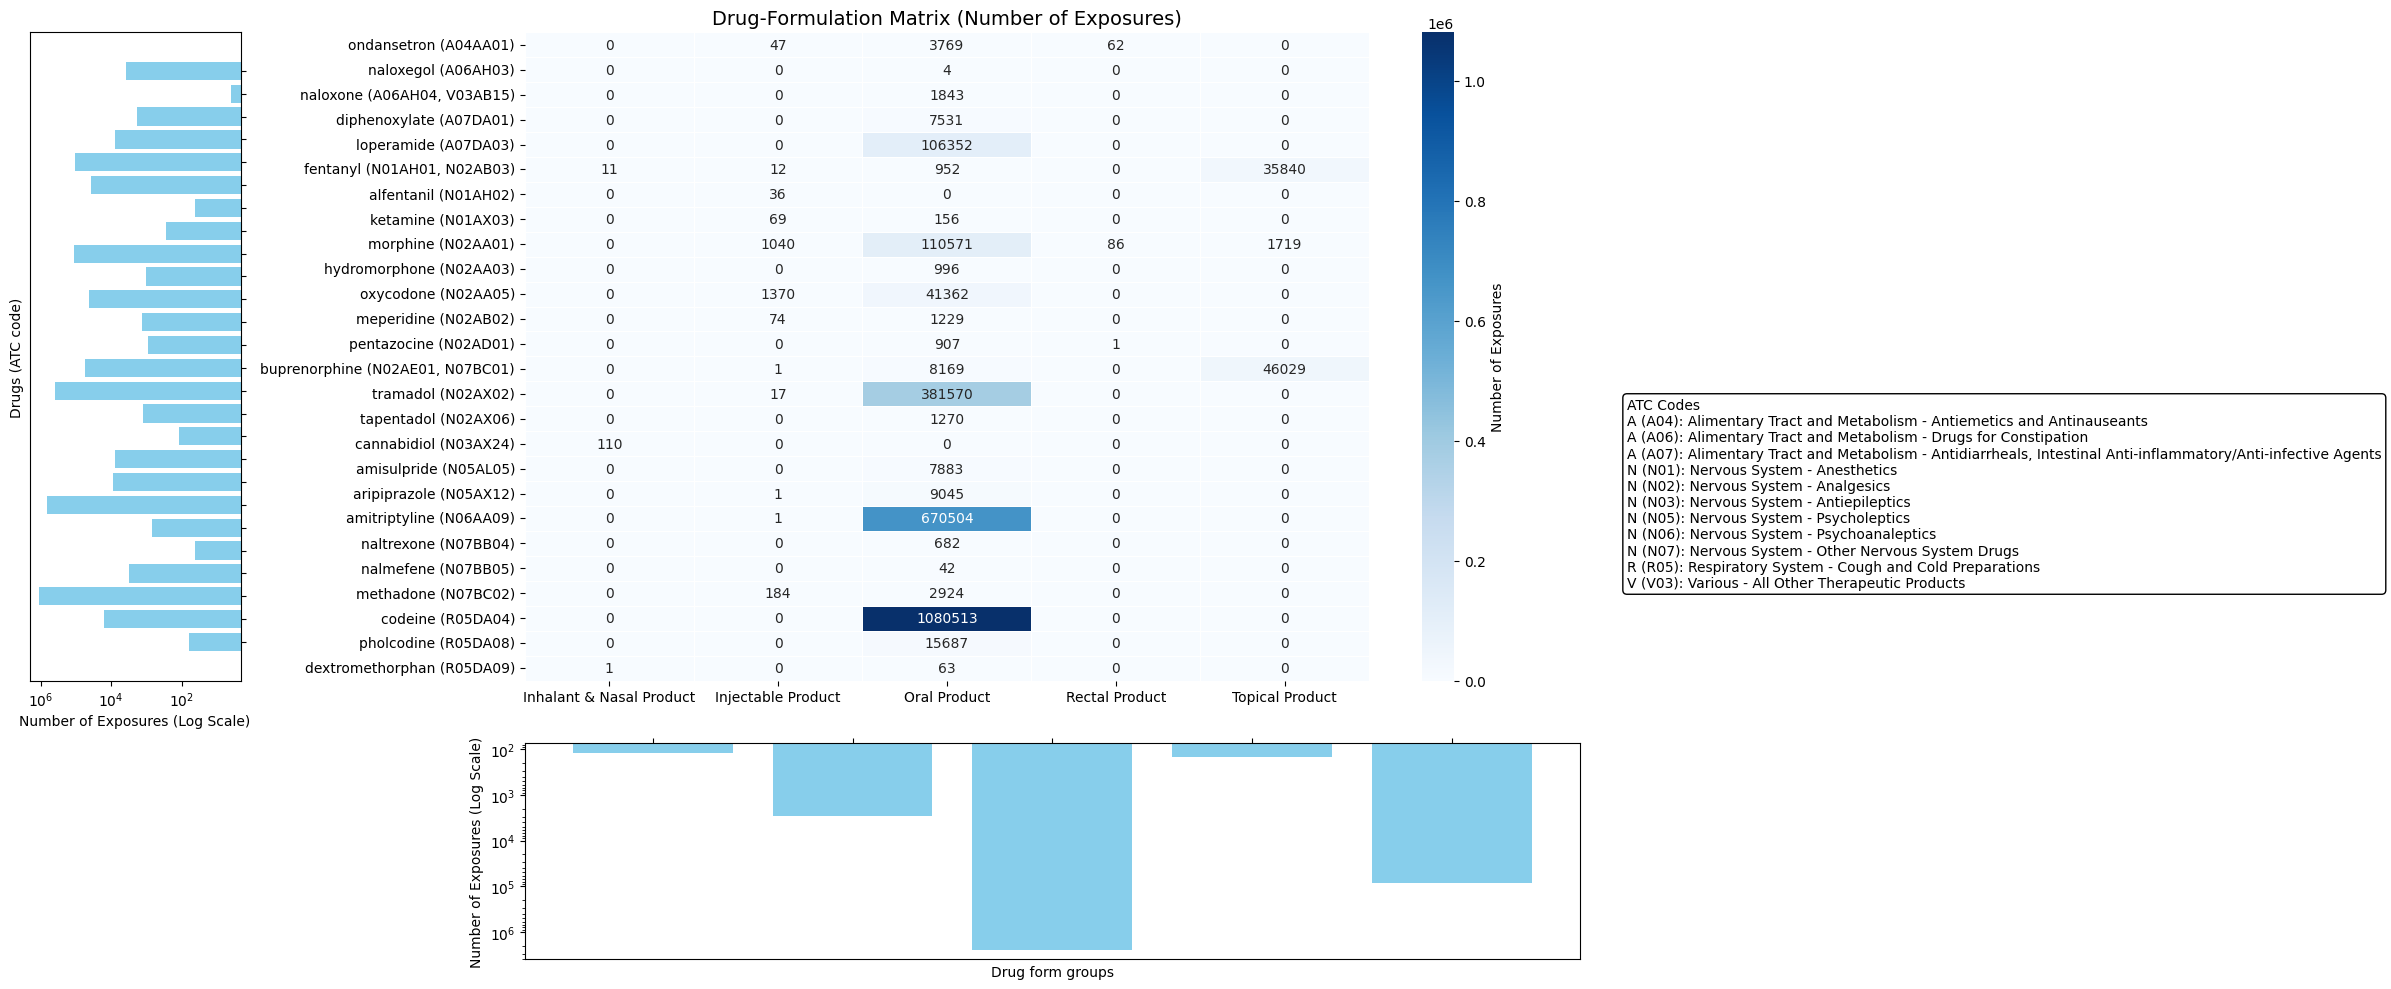

In [ ]:
# Prepare histograms data
# 1: Left histogram (drug exposure count)
drug_counts = (
    final_df_with_dose_form_with_group_pd.groupby("drug_name")
    .size()
    .reset_index(name="exposure_count")
)

# 2: Bottom histogram (formulation exposure count)
formulation_counts = (
    final_df_with_dose_form_with_group_pd.groupby("drug_form_group")
    .size()
    .reset_index(name="exposure_count")
)

# Step 2: Create the mapping of drugs to their ATC codes
drug_atc_mapping = (
    filtered_df_atc.groupby("concept_name")["ATC"]
    .apply(lambda x: ", ".join(sorted(x.unique())))
    .to_dict()
)

# Order drugs based on ATC code (same approach as in your example)
ordered_drugs = sorted(
    final_df_with_dose_form_with_group_pd["drug_name"].unique(),
    key=lambda drug: drug_atc_mapping.get(drug, "ZZZ"),
)


# Step 4: Create the ATC legend with first and second-level codes and their meanings
atc_legend = filtered_df_atc[
    ["ATC_First_Level", "First_Level_Name", "ATC_Second_Level", "Second_Level_Name"]
].drop_duplicates()
atc_legend = atc_legend.sort_values(
    by=["First_Level_Name", "ATC_First_Level", "ATC_Second_Level"],
    ascending=[True, True, True],
)
atc_legend_text = "\n".join(
    [
        f"{row['ATC_First_Level']} ({row['ATC_Second_Level']}): {row['First_Level_Name']} - {row['Second_Level_Name']}"
        for _, row in atc_legend.iterrows()
    ]
)

# Step 5: Add ATC codes to the drug names
ordered_drug_labels = [
    f"{drug} ({drug_atc_mapping.get(drug, 'N/A')})" for drug in ordered_drugs
]

# Step 6: Create the drug-formulation exposure matrix
heatmap_df = drug_formulation_counts.pivot_table(
    index="drug_name",
    columns="drug_form_group",
    values="exposure_count",
    aggfunc="sum",
    fill_value=0,
)

# Reorder the rows of the matrix to match the ordered drugs
heatmap_df = heatmap_df.reindex(ordered_drugs)

# Update the matrix row labels to include ATC codes
heatmap_df.index = ordered_drug_labels

# Step 7: Prepare histograms data (Drug and Formulation counts)
merged_drug_counts = drug_counts.merge(
    pd.DataFrame(list(drug_atc_mapping.items()), columns=["drug_name", "ATC"]),
    on="drug_name",
    how="left",
)

ordered_drug_counts = merged_drug_counts.set_index("drug_name").loc[ordered_drugs]

# Step 8: Create the plot
fig, axes = plt.subplots(
    2,
    2,
    figsize=(16, 10),
    gridspec_kw={"width_ratios": [1, 5], "height_ratios": [6, 2]},
)

# ----- LEFT PLOT: VERTICAL HISTOGRAM (DRUGS) ----
axes[0, 0].barh(
    ordered_drug_labels,
    ordered_drug_counts["exposure_count"],
    color="skyblue",
    align="center",
)
axes[0, 0].set_xscale("log")
axes[0, 0].set_xlabel("Number of Exposures (Log Scale)", fontsize=10)
axes[0, 0].set_ylabel("Drugs (ATC code)", fontsize=10)
axes[0, 0].invert_xaxis()
axes[0, 0].invert_yaxis()
axes[0, 0].tick_params(axis="y", labelleft=False, right=True, left=False)

# ----- RIGHT PLOT: HEATMAP ----
# Create a mask for zero values
sns.heatmap(
    heatmap_df,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={"label": "Number of Exposures"},
    ax=axes[0, 1],
)

axes[0, 1].set_xlabel("")
axes[0, 1].set_ylabel("")  # Hide y-axis label
axes[0, 1].set_title("Drug-Formulation Matrix (Number of Exposures)", fontsize=14)
axes[0, 1].tick_params(axis="y", labelleft=True, rotation=0)

# ----- BOTTOM PLOT: HORIZONTAL HISTOGRAM (FORMULATIONS) ----
axes[1, 1].bar(
    formulation_counts["drug_form_group"],
    formulation_counts["exposure_count"],
    color="skyblue",
    align="center",
)
axes[1, 1].set_ylabel("Number of Exposures (Log Scale)", fontsize=10)
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel("Drug form groups", fontsize=10)
axes[1, 1].invert_yaxis()
axes[1, 1].tick_params(axis="x", labelbottom=False, top=True, bottom=False)

# Hide the empty bottom-left subplot
axes[1, 0].axis("off")

# ----- ADD ATC LEGEND -----
plt.figtext(
    1.02,
    0.5,
    "ATC Codes\n" + atc_legend_text,
    wrap=True,
    fontsize=10,
    verticalalignment="center",
    bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
)

# Adjust layout to fit everything nicely
plt.tight_layout()

# Save the plot
plt.savefig(
    "drug_formulation_heatmap_with_drug_usage.png", dpi=300, bbox_inches="tight"
)

# Show the plot
plt.show()

In [ ]:
# Calculate the total exposure count
total_exposure_count = formulation_counts['exposure_count'].sum()

# Calculate the percentage for each drug_form_group
formulation_counts['percentage'] = (formulation_counts['exposure_count'] / total_exposure_count) * 100

# Print the results
print(formulation_counts)

            drug_form_group  exposure_count  percentage
0  Inhalant & Nasal Product             122    0.004802
1        Injectable Product            2852    0.112251
2              Oral Product         2454024   96.587169
3            Rectal Product             149    0.005864
4           Topical Product           83588    3.289914


## Now we want to add this information of drug form group to drug era table

In [77]:
# Filter the OMOP dataset for relevant drug_concept_id
filtered_df_era = df_era.filter(col("drug_concept_id").isin(drug_concept_ids))
# Format date columns
filtered_df_era = filtered_df_era.withColumn(
    "drug_era_start_date", to_date(col("drug_era_start_date"), "dd/MM/yyyy")
).withColumn("drug_era_end_date", to_date(col("drug_era_end_date"), "dd/MM/yyyy"))

# Show the result of the filter
filtered_df_era.drop("eid").show(truncate=False)
filtered_df_era.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|
+-------------+---------------+-------------------+-----------------+-------------------+--------+
|523986031867 |1201620        |2005-01-04         |2005-02-02       |1                  |0       |
|1194000909628|1133201        |1993-08-20         |1993-10-26       |2                  |9       |
|704374697810 |1201620        |2008-07-29         |2008-10-17       |2                  |22      |
|68719563134  |710062         |1996-11-11         |1996-11-20       |1                  |0       |
|1236950640019|710062         |2010-07-20         |2010-07-29       |1                  |0       |
|575525667834 |1201620        |2015-05-28         |2015-06-26       |1                  |0       |
|781684097755 |1201620        |2009-12-24         |2010-01-07       |1                  |0       |
|300647715

869262

In [ ]:
# Perform the join and filtering
# Step 1: Perform the join and filtering
df_joined = filtered_df_era.alias("era").join(
    final_df_with_dose_form_with_group.alias("exp"),
    (col("era.eid") == col("exp.eid"))
    & (col("era.drug_concept_id") == col("exp.ingredient_concept_id"))
    & (
        col("exp.drug_exposure_start_date").between(
            col("era.drug_era_start_date"), col("era.drug_era_end_date")
        )
    ),
    "left",
)

# Step 2: Count exposures per `drug_form_group`
df_counted = df_joined.groupby(
    "era.eid",
    "era.drug_era_id",
    "era.drug_concept_id",
    "era.drug_era_start_date",
    "era.drug_era_end_date",
    "era.drug_exposure_count",
    "era.gap_days",
    "exp.drug_name",
    "exp.drug_form_group",
).agg(count("exp.drug_form_group").alias("exposure_count"))

# Step 3: Aggregate lists for `drug_form_group` and their corresponding counts
df_era_with_drug_form_group = df_counted.groupby(
    "eid",
    "drug_era_id",
    "drug_concept_id",
    "drug_era_start_date",
    "drug_era_end_date",
    "drug_exposure_count",
    "gap_days",
    "drug_name",
).agg(
    collect_list("drug_form_group").alias(
        "drug_form_group"
    ),  # List of drug form groups
    collect_list("exposure_count").alias(
        "exposure_counts_to_drug_form_group"
    ),  # List of respective exposure counts
)

# Show the result
df_era_with_drug_form_group.drop("eid").show(truncate=False)
df_era_with_drug_form_group.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+-------------+---------------+----------------------------------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug_name    |drug_form_group|exposure_counts_to_drug_form_group|
+-------------+---------------+-------------------+-----------------+-------------------+--------+-------------+---------------+----------------------------------+
|1228360666726|710062         |2014-03-10         |2014-03-17       |1                  |0       |amitriptyline|[Oral Product] |[1]                               |
|1245540543307|710062         |2010-04-23         |2010-04-30       |1                  |0       |amitriptyline|[Oral Product] |[1]                               |
|549755901823 |1201620        |2008-09-18         |2008-10-18       |2                  |0       |codeine      |[Oral Product] |[2]                               |
|790273984595 |1

869262

In [ ]:
# Filter rows where the drug_form_group array has more than one element
df_era_with_multiple_drug_form_groups = df_era_with_drug_form_group.filter(
    size(col("drug_form_group")) > 1
)

# Show the result
df_era_with_multiple_drug_form_groups.drop("eid").show(truncate=False)

# Count the rows with more than one drug_form_group
df_era_with_multiple_drug_form_groups.count()

+-------------+---------------+-------------------+-----------------+-------------------+--------+-------------+-------------------------------------+----------------------------------+
|drug_era_id  |drug_concept_id|drug_era_start_date|drug_era_end_date|drug_exposure_count|gap_days|drug_name    |drug_form_group                      |exposure_counts_to_drug_form_group|
+-------------+---------------+-------------------+-----------------+-------------------+--------+-------------+-------------------------------------+----------------------------------+
|944892898785 |1124957        |2015-01-20         |2015-02-18       |2                  |0       |oxycodone    |[Injectable Product, Oral Product]   |[1, 1]                            |
|764504211584 |1110410        |2011-04-18         |2011-06-25       |6                  |0       |morphine     |[Topical Product, Oral Product]      |[2, 4]                            |
|987842498863 |1110410        |2014-05-02         |2014-06-21       |2

970

Now lets save a file with the drugs of interests for further analysis (specify which opioids you want to keep)

In [ ]:
# Assuming you want to choose, for example, 'morphine' and 'codeine'
drugs_to_keep = ["morphine", "codeine"]
# Filter the rows based on the drugs you want to keep
filtered_df_era_with_drug_form_group = df_era_with_drug_form_group.filter(
    df_era_with_drug_form_group["drug_name"].isin(drugs_to_keep)
)

filtered_df_era_with_drug_form_group_pd = (
    filtered_df_era_with_drug_form_group.toPandas()
)

# Save the pandas DataFrame as a TSV file
filtered_df_era_with_drug_form_group_pd.to_csv(
    "morphine_codeine_df_era_with_drug_form_group.tsv", sep="\t", index=False
)